# **ADApocalypse presents:** "Her Side Story" - Beyond the Bechdel Test: Studying How Women Are Put Aside in Cinema 

## Project Initialisation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
tqdm.pandas()
import json
from collections import defaultdict
from transformers import pipeline
import ast

# not displaying warnings
pd.options.mode.chained_assignment = None 

# to facilitate the use of py files
%load_ext autoreload
%autoreload 2



### Constants

In [2]:
DATA_FOLDER_PATH = 'src/data/raw_data/'
CLUSTER_JSON_PATH =  'src/data/clusters.json'

### Filtering and transformation of several columns

# 1. Loading files


## A. CMU Movie dataset

Instead of loading the raw files from the CMU movie dataset, we load the preprocessed files.

In [3]:
from src.data.data_loader import load_movies_metadata, load_char_metadata, load_plot_summaries, load_tvtropes_data, load_name_clusters


In [4]:
PREPROCESSED_DATA_FOLDER_PATH = 'src/data/preprocessed_data/'

movies_metadata_df = pd.read_csv(PREPROCESSED_DATA_FOLDER_PATH+'movie.metadata_preprocessed.csv', skiprows=1,
                    names=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date',
                        'movie_box_office_revenue', 'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres'])
char_metadata_df = pd.read_csv(PREPROCESSED_DATA_FOLDER_PATH+'character.metadata_preprocessed.csv', skiprows=1,
                names=['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'char_name',
                    'actor_date_of_birth', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', 
                    'char_actor_id', 'char_id', 'actor_id'])

plot_summaries_df = load_plot_summaries(DATA_FOLDER_PATH)
tvtropes_df = load_tvtropes_data(DATA_FOLDER_PATH)
name_clusters_df = load_name_clusters(DATA_FOLDER_PATH)

In [5]:
tvtropes_df = load_tvtropes_data(DATA_FOLDER_PATH)

# 2. Filtering the movies

We decided to filter our raw data in order to keep the movie intersection of the 3 following files: movie.metadata, character.metadata and imdb.ratings.

We applied the following rules to filter and preprocess the files: 
- all movies without release date were dropped
- all movies with a release date outside of the range 1910-2013 were dropped
- the release date were standardized into realase year
- thanks to another external dataset the missing gender were added
- the characters without a gender were dropped 

In [6]:
# from src.utils.methods import get_intersection

# movies_metadata_df, char_metadata_df, intersection_ids = get_intersection(movies_metadata_df, char_metadata_df)


Now, our dataframes are preprocessed and contain the same movies.

In [7]:
# print(f'We now have {intersection_ids.shape[0]} movies.')

We export them and store them for easy reuse.

In [8]:
# movies_metadata_df.to_csv("src/data/preprocessed_data/movie.metadata_preprocessed.csv", index=False)
# char_metadata_df.to_csv("src/data/preprocessed_data/character.metadata_preprocessed.csv", index=False)

We noticed that the columns languages and genres of the movie.metadata.csv were very broad and included a large number of different propositions, such as more than 20 different Indian dialects. In order to perform a complete analysis without getting lost in interpretation we decided to cluster them. Moreover, some countries have been wrongly labeled or are ancient territories, which we clusted for equivalent reasons.

## 2.1 Loading External datasets

Loading IMDB dataset. We plan to use it in the future to evaluate the success of a movie and link it with the genders of the actors.

The title.basics.tsv and title.ratings.tsv files are too big to be stored in the repository so all results are pre run but cannot be find again.

In [9]:
# from src.utils.methods import process_imdb_ratings

# imdb_ratings_df = process_imdb_ratings(movies_metadata_df)

# loading imdb ratings
imdb_ratings_df = pd.read_csv("src/data/external_data/imdb_ratings.csv")

In [10]:
imdb_ratings_df.head()

,wikipedia_movie_id,imdb_movie_id,movie_name,movie_release_date,averageRating,numVotes
0,975900,tt0228333,Ghosts of Mars,2001,4.9,58732.0
1,28463795,tt0094806,Brun bitter,1988,5.6,42.0
2,9363483,tt0094320,White Of The Eye,1987,6.1,3071.0
3,261236,tt0083949,A Woman in Flames,1983,5.9,648.0
4,10408933,tt0029852,Alexander's Ragtime Band,1938,6.8,2353.0


In [11]:
imdb_ratings_df.shape

(44868, 6)

Loading Bechdel Dataset. We plan to use it to conduct gender analysis.

In [12]:
# from src.utils.methods import process_bechdel_ratings

# bechdel_ratings_df = process_bechdel_ratings(movies_metadata_df)

# loading bechdel ratings

bechdel_ratings_df = pd.read_csv("src/data/external_data/bechdel_ratings.csv")

In [13]:
bechdel_ratings_df.head()

,wikipedia_movie_id,movie_name,movie_release_date,bechdel_rating
0,975900,Ghosts of Mars,2001,3
1,171005,Henry V,1989,3
2,77856,Mary Poppins,1964,3
3,12053509,Loverboy,1989,3
4,1369204,Juarez,1939,2


In [14]:
bechdel_ratings_df.shape

(3886, 4)

In [15]:
bechdel_ratings_df["bechdel_rating"].value_counts()

bechdel_rating
3    2142
1     942
2     430
0     372
Name: count, dtype: int64

The bechdel ratings dataset must be used as follows:
- 0 --> there are not two women in the movie. test fails.
- 1 --> there are two women but they do not speak to each other. test fails.
- 2 --> the two women speak to each other but about a man. test fails.
- 3 --> two women speak of something else than a man. test passes.

# 1. MOVIES

## 1.1 METADATA

### In order to perform a complete analysis, we intend to further add the columns 'director_name', 'director_gender' and 'budget' to the movies_metadata dataframe, thanks to the wikipedia_movie_id allowing us to access the library wikipedia_api

In [16]:
movies_metadata_df.shape

(59776, 9)

In [17]:
movies_metadata_df.isnull().sum()

wikipedia_movie_id              0
freebase_movie_id               0
movie_name                      0
movie_release_date              0
movie_box_office_revenue    51619
movie_runtime               10451
movie_languages                 0
movie_countries                 0
movie_genres                    0
dtype: int64

In [18]:
print(f"There are {movies_metadata_df['wikipedia_movie_id'].nunique()} unique wikipedia_movie_id")
print(f"and there are {movies_metadata_df['freebase_movie_id'].nunique()} unique freebase_movie_id")
print(f"but there are {movies_metadata_df['movie_name'].nunique()} unique movie_name")
print(f"and there are {movies_metadata_df.shape[0]} rows in the dataset")


There are 59776 unique wikipedia_movie_id
and there are 59776 unique freebase_movie_id
but there are 55392 unique movie_name
and there are 59776 rows in the dataset


In [19]:
def extract_names_from_tuples(languages):
    lang_dict = ast.literal_eval(languages)
    return list(lang_dict.values())

We want to change the format of the column languages, countries and genres from tuple to list, because the freebase ids are not relevant.

In [20]:
movies_metadata_df['movie_languages'] = movies_metadata_df['movie_languages'].apply(extract_names_from_tuples)
movies_metadata_df['movie_countries'] = movies_metadata_df['movie_countries'].apply(extract_names_from_tuples)
movies_metadata_df['movie_genres'] = movies_metadata_df['movie_genres'].apply(extract_names_from_tuples)

We have seen that there are a lot of different languages, countries and genres (mettre les chiffres), sometimes they were repetive and not consistent. We decided to create manually different clusters in clusters.json file. We import the clusters.

In [21]:
with open(CLUSTER_JSON_PATH, 'r') as file:
    data = json.load(file)

In [22]:
languages_cluster = data['Languages']
countries_cluster = data['Countries']
genres_cluster = data['Genres']


In [23]:
def map_cluster(mapping, elem):
    for generic, variants in mapping.items():
        if elem in variants:
            return generic
    return elem

In [24]:
movies_metadata_df['movie_languages'] = movies_metadata_df['movie_languages'].apply(lambda x: list(dict.fromkeys([map_cluster(languages_cluster, elem) for elem in x]).keys()))
movies_metadata_df['movie_countries'] = movies_metadata_df['movie_countries'].apply(lambda x: list(dict.fromkeys([map_cluster(countries_cluster, elem) for elem in x]).keys()))
movies_metadata_df['movie_genres'] = movies_metadata_df['movie_genres'].apply(lambda x: list(dict.fromkeys([map_cluster(genres_cluster, elem) for elem in x]).keys()))

### 1.1.1 GENRES

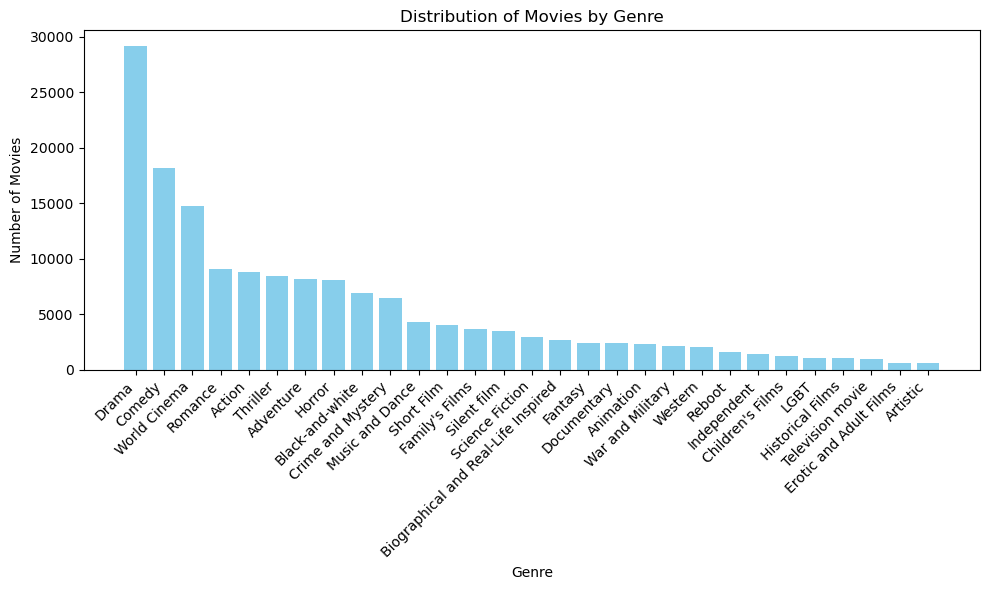

In [25]:
all_genres = movies_metadata_df['movie_genres'].copy()
all_genres = [genre for sublist in movies_metadata_df['movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

genre_df = genre_df.sort_values(by='Count', ascending=False)
# keep only the genres with more than 500 movies
genre_df = genre_df[genre_df['Count'] > 500]

# Plot the distribution of genres
plt.figure(figsize=(10, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The first analysis of the movie genres give us ideas and insights on how to conduct our future analysis.

From this distribution of movies by genre, we could select the top-10 genres and look at the gender distribution on them. 

Additionnally, we will also focus on some other genres because of clichés that we have spotted while doing the genre clustering:
- feminist films
- pornographic films
- LGBT films
- war and military films


### 1.1.2. LANGUAGES

We investigated this feature about the movie dataset and we have seen that it is quite similar to the country feature. Hence, we decide for further analysis to focus on the country feature since it can give us information about how a country's culture can influence the gender representation in movies.

### 1.1.3. COUNTRIES

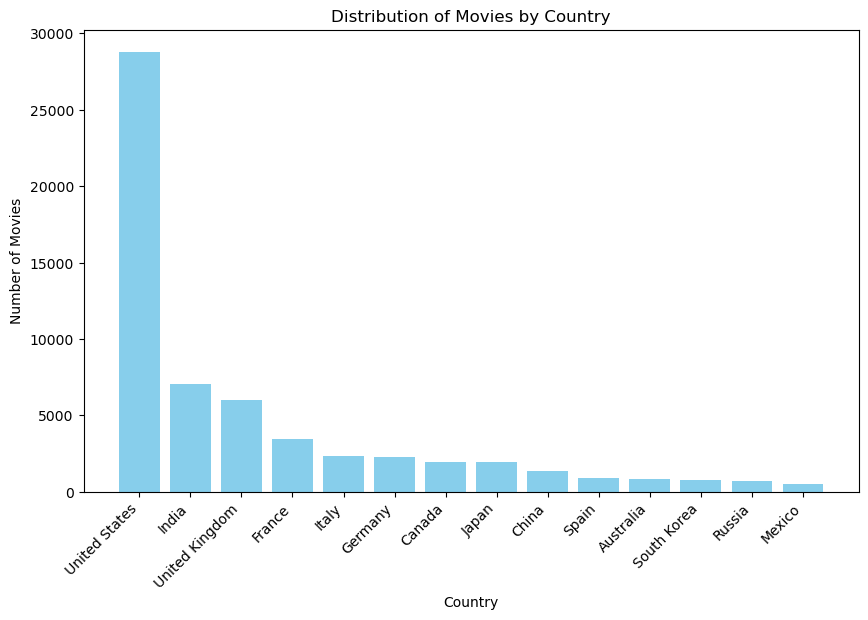

In [26]:
all_countries = movies_metadata_df['movie_countries'].copy()
all_countries = [country for sublist in movies_metadata_df['movie_countries'] for country in sublist]
countries_counts = Counter(all_countries)

country_df = pd.DataFrame(countries_counts.items(), columns=['Country', 'Count'])
country_df = country_df.sort_values(by='Count', ascending=False)
country_df = country_df[country_df['Count'] > 500]

plt.figure(figsize=(10, 6))
plt.bar(country_df['Country'], country_df['Count'], color='skyblue')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies by Country')
plt.xticks(rotation=45, ha='right') 
plt.show()

We can see that we have a lot of movies from USA, UK, and Europe. Our analysis would be occidental-centered with an exception for India and north Asia countries.

It could be really interesting to look at the difference of the gender representation depending on the part of the world. 

### 1.1.4. Box office revenue

There is a lot of missing values (more than 50%), we would like to add an external dataset. We could link it to a movie success in order to look for any correlation with the gender distribution of actors.

### 1.1.5. Runtime

In [27]:
movies_metadata_df['movie_runtime'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 59776 entries, 0 to 59775
Series name: movie_runtime
Non-Null Count  Dtype  
--------------  -----  
49325 non-null  float64
dtypes: float64(1)
memory usage: 467.1 KB


There is some missing runtime values. We are still thinking about whether to use the runtime or not and hence if we should find values to remplace them.

Here are some statistics about the runtime. We can see that the minimum and maximum runtime are extreme, we could look into that more carefully in order to know why. It could also be interesting to explore if there is any correlation with the gender of the actors or characters.

In [28]:
movies_metadata_df['movie_runtime'].describe()

count    4.932500e+04
mean     1.196767e+02
std      4.859412e+03
min      1.500000e-01
25%      8.500000e+01
50%      9.500000e+01
75%      1.090000e+02
max      1.079281e+06
Name: movie_runtime, dtype: float64

### 1.1.6. Release date

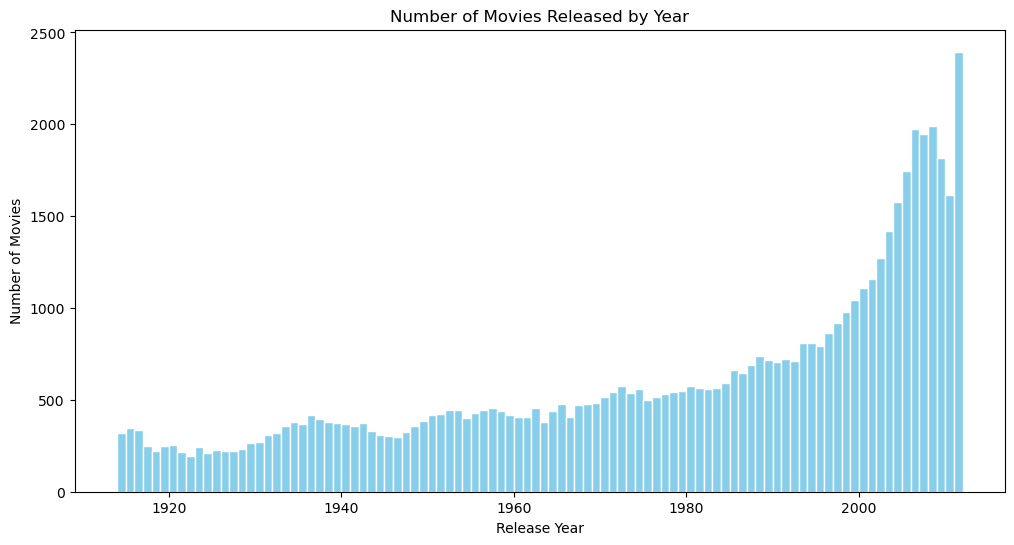

In [29]:
movies_metadata_df['movie_release_date'] = movies_metadata_df['movie_release_date'].apply(lambda x: int(x))

plt.figure(figsize=(12, 6))
plt.hist(movies_metadata_df['movie_release_date'], bins=range(movies_metadata_df['movie_release_date'].min(), movies_metadata_df['movie_release_date'].max() + 1), color='skyblue', edgecolor='white')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released by Year')
plt.show()

We can observe that the distribution of movies produced between 1910 until 2013 follows a heavy left-skewed distribution, with a notable increase during World War I. We can now wonder whether the temporal evolution of the number of movies follows the same distribution depending on the gender of the director.

# 2. CHARACTERS

## 2.1. METADATA

We use the preprocessed dataframe.

### 2.1.1. Distributions of characters per movie

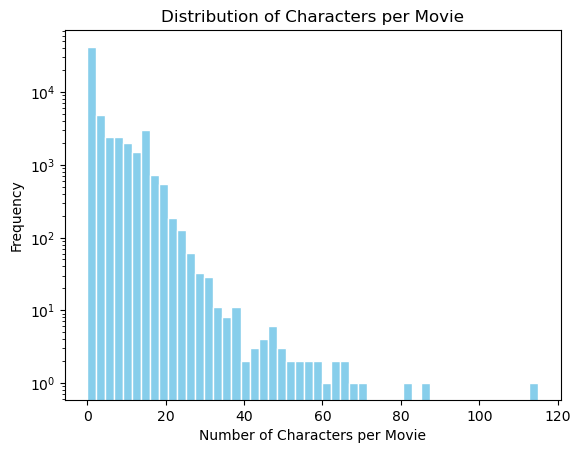

In [30]:
char_per_movie = char_metadata_df.groupby("wikipedia_movie_id")['char_name'].count().reset_index()
max_characters = char_per_movie['char_name'].max()
max_movie_id = char_per_movie[char_per_movie['char_name'] == max_characters]['wikipedia_movie_id'].values[0]

plt.hist(char_per_movie['char_name'], bins=50, log=True, color = "skyblue", edgecolor="white") 
plt.xlabel('Number of Characters per Movie')
plt.ylabel('Frequency')
plt.title('Distribution of Characters per Movie')
plt.show()

This plot shows us that the majority of movies register less than 20 characters, although the distribution is pretty constant until ~45 characters. We also notice a few outliers with more than 80 and 115 characters per movie. It would be interesting to link those results alongside with the runtime of the movie and the gender of the director.

### 2.1.2. Distribution of female and male characters

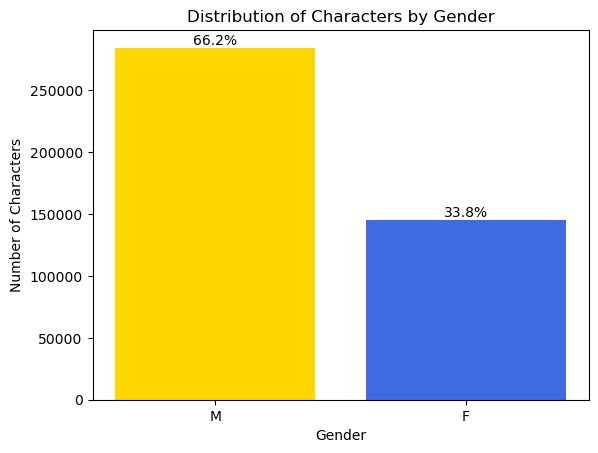

In [31]:
characters_gender = char_metadata_df[char_metadata_df["actor_gender"].isin(["F", "M"])]
gender_counts = characters_gender["actor_gender"].value_counts()

total_characters = gender_counts.sum()
percentages = (gender_counts / total_characters) * 100

plt.bar(gender_counts.index, gender_counts.values, color=['gold', 'royalblue'])
plt.xlabel('Gender')
plt.ylabel('Number of Characters')
plt.title('Distribution of Characters by Gender')

for index, (count, percentage) in enumerate(zip(gender_counts.values, percentages)):
    plt.text(index, count, f'{percentage:.1f}%', ha='center', va='bottom')


This graph illustrates genre inequalities amongst movie characters. As we can see, overall only 1/3 of the characters are female. A further analysis would be to compare the distribution of movie characters between genders based on the genre, gender of the movie director and release date of the movie.

Let's groupby on release_years_df to get also the number of movies

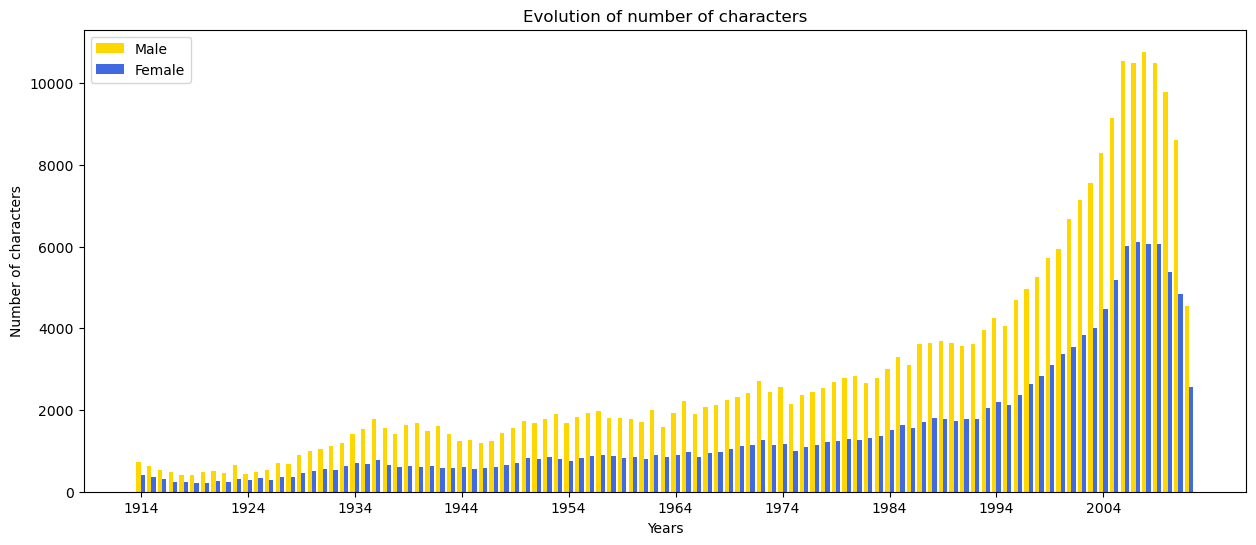

In [32]:
# convert genders into numbers
char_metadata_df["actor_gender_binary"] = char_metadata_df["actor_gender"].apply(lambda x: 0 if x=="M" else 1)
characters_gender_time = char_metadata_df.groupby("movie_release_date")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()

release_years_df = char_metadata_df.groupby("movie_release_date")["wikipedia_movie_id"].count()
characters_gender_time["Num_movies"] = release_years_df.values

fig, ax = plt.subplots(figsize=(15,6))
width = 0.4
x = characters_gender_time.index  # Years
x_male = x - width / 2
x_female = x + width / 2

# Plot bars side by side
ax.bar(x_male, characters_gender_time[0], width, label="Male", color="gold")
ax.bar(x_female, characters_gender_time[1], width, label="Female", color="royalblue")
ax.set_title("Evolution of number of characters")
ax.legend()
ax.set_ylabel("Number of characters")
ax.set_xlabel("Years")
ax.set_xticks(x[::10])  # Adjust to show ticks every 30 years
ax.set_xticklabels(characters_gender_time["movie_release_date"][::10]);

Overall, there are consequently more male than female characters, almost double amount. They both follow the same left-skewed distribution, which is due to the augmenting number of movies over the period studied.

### 2.1.3. Proportion of female characters

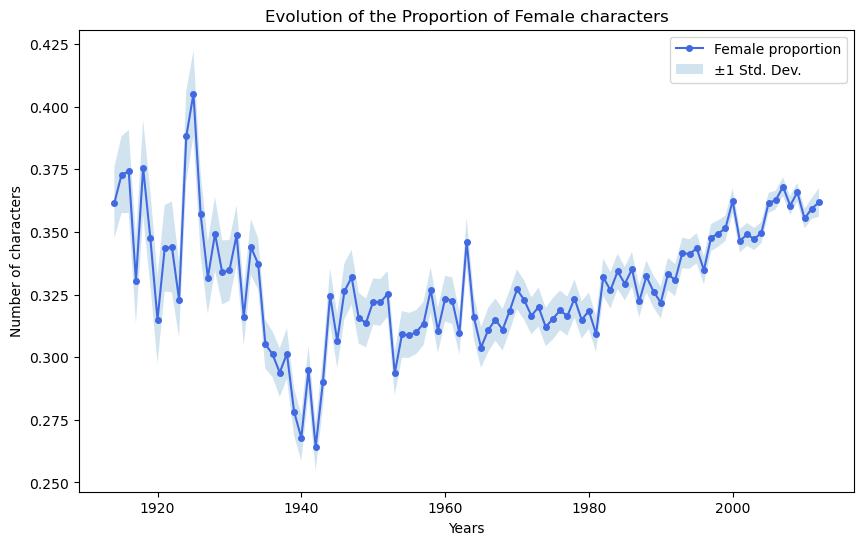

In [33]:
characters_gender_time["proportion_F"] = characters_gender_time[1]/ (characters_gender_time[1]+characters_gender_time[0])
characters_gender_time["std_F"] = np.sqrt((characters_gender_time["proportion_F"]*(1-characters_gender_time["proportion_F"])) / (characters_gender_time[1]+characters_gender_time[0]))
characters_gender_time_filtered = characters_gender_time[characters_gender_time["Num_movies"] >= 200]

y_err = characters_gender_time_filtered["std_F"]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(characters_gender_time_filtered["movie_release_date"], characters_gender_time_filtered["proportion_F"], "-o", label="Female proportion", color="royalblue", markersize=4)
ax.fill_between(characters_gender_time_filtered["movie_release_date"], characters_gender_time_filtered["proportion_F"] - y_err, characters_gender_time_filtered["proportion_F"] + y_err, alpha=0.2, label='±1 Std. Dev.')
ax.set_title("Evolution of the Proportion of Female characters")
ax.set_xlabel("Years")
ax.set_ylabel("Number of characters")
ax.legend()

Interestingly, the number of female characters over the years reached its maximum (around 40%) in 1925, which correspond to the introduction of sound in movies. The proportion then drastically dropped until 1942, with over a fourth of the characters represented by women. It then increased and stabilized at around 30-35%, where it steadily increased reaching  36% in 2013.

### 2.1.4. Distribution of the actor's ages

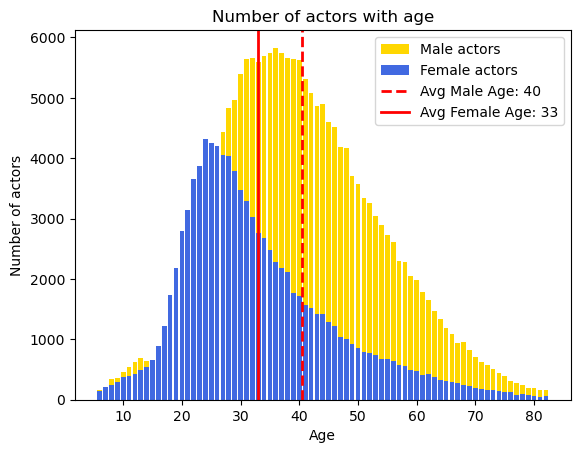

In [34]:
actors_age = char_metadata_df.copy(deep=True)
actors_age_gender = actors_age.groupby("actor_age")["actor_gender_binary"].value_counts().unstack(fill_value=0).reset_index()
actors_age_gender["Tot_actors"] = actors_age_gender[0] + actors_age_gender[1]
actors_age_gender = actors_age_gender[actors_age_gender["Tot_actors"] >= 200]

# Calculate weighted average age for each gender
avg_age_male = (actors_age_gender['actor_age'] * actors_age_gender[0]).sum() / actors_age_gender[0].sum()
avg_age_female = (actors_age_gender['actor_age'] * actors_age_gender[1]).sum() / actors_age_gender[1].sum()

fig, ax = plt.subplots()

ax.bar(actors_age_gender['actor_age'], actors_age_gender[0], label="Male actors", color="gold")
ax.bar(actors_age_gender['actor_age'], actors_age_gender[1], label="Female actors", color="royalblue")

ax.axvline(avg_age_male, color="red", linestyle="--", linewidth=2, label=f"Avg Male Age: {avg_age_male:.0f}")
ax.axvline(avg_age_female, color="red", linestyle="-", linewidth=2, label=f"Avg Female Age: {avg_age_female:.0f}")

#get handles and labels
handles, labels = ax.get_legend_handles_labels()
    
# #specify order of items in legend
order = [2, 3, 0, 1]

#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_title("Number of actors with age")
ax.set_xlabel("Age")
ax.set_ylabel("Number of actors");

This graph illustrates the inequalities regarding opportunities given to older actors. Whereas the majority of male actors are between 30 and 50 years old, with an average of 40 years old, most women actors are only between 20 and 30 years old, with an average of 33 years old. The male actors seem to have a longer career than female ones. Once again, it would be interesting to compare this number according to the gender of the movie director and the genre of the movie. 

### 2.1.5 Gender representation in the different parts of the world

Check if some actors appear twice in the same movie. Do another one on the actors genders. Do a csv with the actors!

In [35]:
movies_countries_df = movies_metadata_df.copy(deep=True)
# only interesting columns
movies_countries_df = movies_countries_df[["wikipedia_movie_id", "movie_release_date", "movie_countries"]]
# groupby to make a list that contains all genders for a given movie
genders_grouped = (
    char_metadata_df.groupby("wikipedia_movie_id")["actor_gender"]
    .apply(list)  # Collect genders into lists
    .reset_index()  # Reset index to make it a DataFrame
    .rename(columns={"actor_gender": "actor_genders"})  # Rename the column
)
# merging
movies_countries_df = movies_countries_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")
movies_countries_df


,wikipedia_movie_id,movie_release_date,movie_countries,actor_genders
0,975900,2001,[United States],"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ..."
1,3196793,2000,[United States],"[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]"
2,28463795,1988,[Norway],"[M, F, M, F]"
3,9363483,1987,[United Kingdom],"[M, F]"
4,261236,1983,[Germany],"[F, M, M]"
...,...,...,...,...
59771,23851782,1941,[United Kingdom],"[F, M, F, M, M, M, F, M, M, F, M, M, M]"
59772,32468537,2007,[Russia],"[M, F, M, M, M, M, M, M, M, M]"
59773,9971909,1972,[United States],"[M, M]"
59774,913762,1992,[Japan],"[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]"


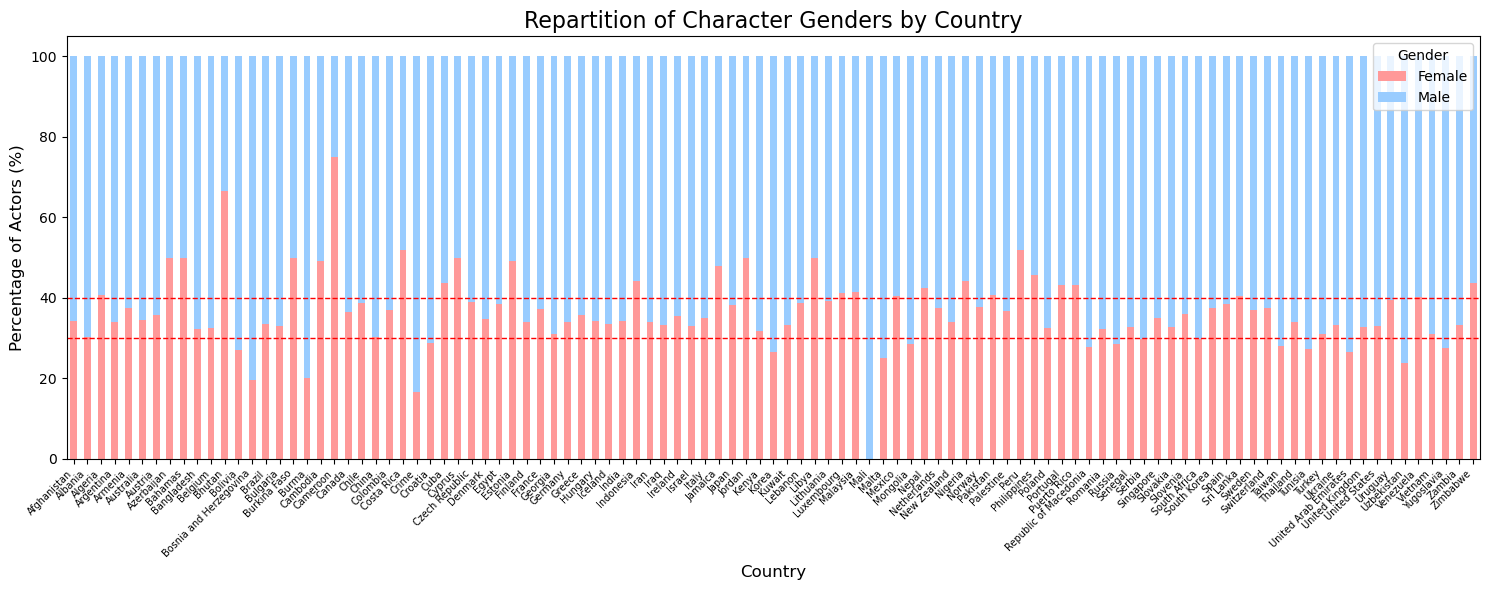

In [208]:
# Explode the data
df_exploded = movies_countries_df.explode("actor_genders")
df_exploded["movie_countries"] = df_exploded["movie_countries"].str[0]  # Flatten country column

# Count genders by country
gender_counts = df_exploded.groupby(["movie_countries", "actor_genders"]).size().unstack(fill_value=0)

# Normalize for percentages
gender_percentages = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the stacked bar chart on the axis
gender_percentages.plot(
    kind="bar",
    stacked=True,
    color=["#FF9999", "#99CCFF"],  # Colors for F, M
    ax=ax  # Use the created axis
)

# Customize the chart
ax.set_title("Repartition of Character Genders by Country", fontsize=16)
ax.set_ylabel("Percentage of Actors (%)", fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=7)
ax.legend(title="Gender", labels=["Female", "Male"], loc="upper right")

# Add a horizontal red line
ax.axhline(y=40, color="red", linestyle="--", linewidth=1)
ax.axhline(y=30, color="red", linestyle="--", linewidth=1)

# Adjust layout
fig.tight_layout()

# Check ceux qui dépassent 50%

Boutan, Cameroun, Mali

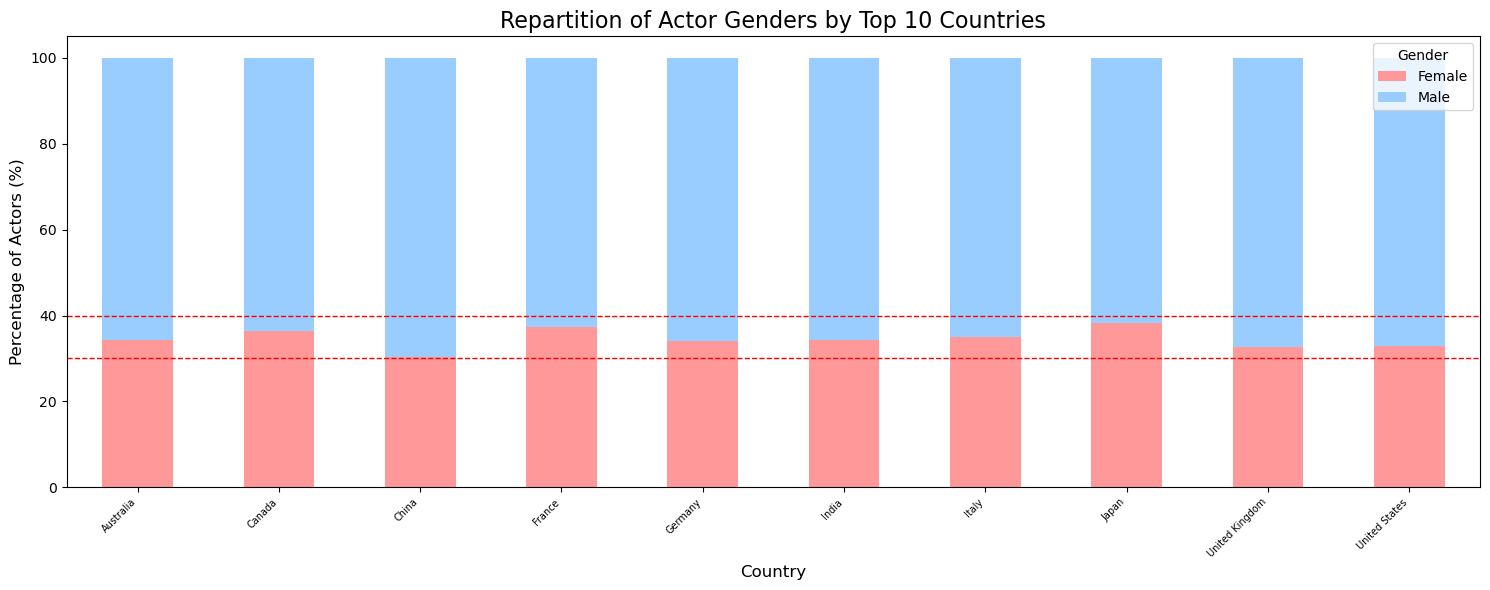

In [85]:
# Step 1: Calculate the number of movies per country
top_countries = df_exploded["movie_countries"].value_counts().head(10).index

# Step 2: Filter for only the top 10 countries
filtered_df = df_exploded[df_exploded["movie_countries"].isin(top_countries)]

# Step 3: Count genders by country
gender_counts_top = (
    filtered_df.groupby(["movie_countries", "actor_genders"])
    .size()
    .unstack(fill_value=0)
)

# Step 4: Normalize for percentages
gender_percentages_top = gender_counts_top.div(gender_counts_top.sum(axis=1), axis=0) * 100

# Step 5: Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the stacked bar chart on the axis
gender_percentages_top.plot(
    kind="bar",
    stacked=True,
    color=["#FF9999", "#99CCFF"],  # Colors for F, M
    ax=ax  # Use the created axis
)

# Customize the chart
ax.set_title("Repartition of Actor Genders by Top 10 Countries", fontsize=16)
ax.set_ylabel("Percentage of Actors (%)", fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=7)
ax.legend(title="Gender", labels=["Female", "Male"], loc="upper right")

# Add a horizontal red line at 50%
# ax.axhline(y=50, color="red", linestyle="--", linewidth=1)
ax.axhline(y=40, color="red", linestyle="--", linewidth=1)
ax.axhline(y=30, color="red", linestyle="--", linewidth=1)

# Adjust layout
fig.tight_layout()


In [105]:
import geopandas as gpd
# Explode the data
df_exploded = movies_countries_df.explode("actor_genders")
df_exploded["movie_countries"] = df_exploded["movie_countries"].str[0]  # Flatten country column

# Count genders by country
gender_counts = df_exploded.groupby(["movie_countries", "actor_genders"]).size().unstack(fill_value=0)

# Normalize for percentages
gender_percentages = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100
# Reset the index for merging
gender_percentages.reset_index(inplace=True)

# Step 2: Load the world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# # Align the country names (if necessary, map custom names)
# # Example: If "USA" is used in gender_percentages but the map uses "United States"
country_mapping = {
    "Malta": "Malta",  # Already matches
    "United States": "United States of America",  # Correct match in `world`
    "Korea": "South Korea",  # Could also check if it refers to North Korea
    "Republic of Macedonia": "North Macedonia",  # Updated name
    "Bosnia and Herzegovina": "Bosnia and Herz.",  # Abbreviation in `world`
    "Crime": "Crimea",  # Likely a typo, verify correctness
    "Singapore": "Singapore",  # Already matches
    "Burma": "Myanmar",  # Modern name for Burma
    "Czech Republic": "Czechia",  # Updated official name
}
# Countries in gender_percentages but not in world:
# {'Singapore', 'Crimea', 'Malta', 'Yugoslavia'}

gender_percentages["movie_countries"] = gender_percentages["movie_countries"].replace(country_mapping)

# Merge with the GeoPandas world dataframe
world = world.merge(gender_percentages, left_on="name", right_on="movie_countries", how="left")

/var/folders/cd/kjm5mz3n3gggv0ytrmlp1nvr0000gp/T/ipykernel_18164/2076015834.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


[]

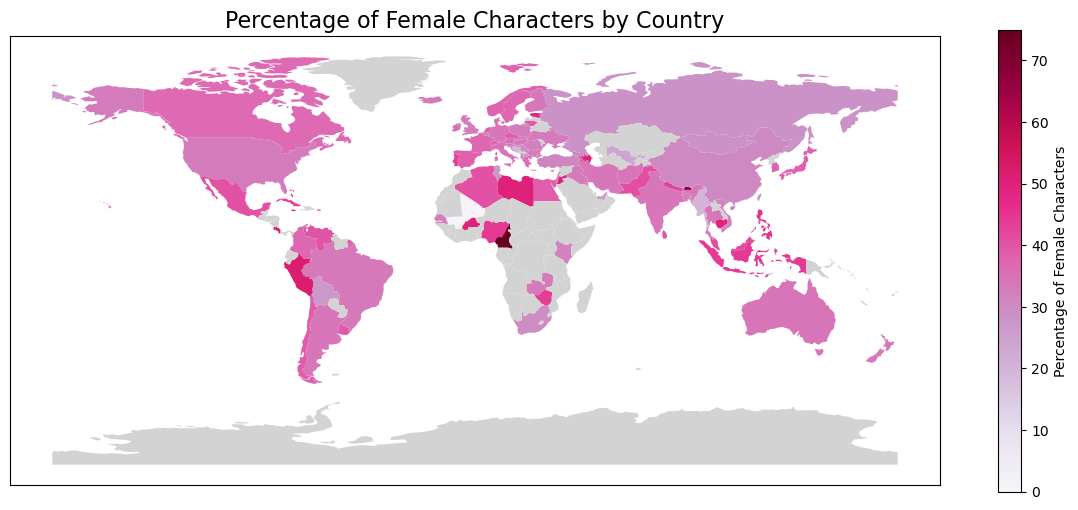

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the choropleth
world.plot(
    column="F",  # Data to visualize
    cmap="PuRd",  # Color map
    legend=True,
    legend_kwds={
            "label": "Percentage of Female Characters",
            "shrink": 0.6,  # Shrink the color scale to make it shorter
            "orientation": "vertical",  # Make the legend vertical
        },
    ax=ax,
    missing_kwds={"color": "lightgrey"},  # Color for countries without data
)

ax.set_title("Percentage of Female Characters by Country", fontsize=16)
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks

### 2.1.6 Gender representation in the different movie genres

In [119]:
movies_genres_df = movies_metadata_df.copy(deep=True)
# only interesting columns
movies_genres_df = movies_genres_df[["wikipedia_movie_id", "movie_release_date", "movie_genres"]]
# merging
movies_genres_df = movies_genres_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")
movies_genres_df

,wikipedia_movie_id,movie_release_date,movie_genres,actor_genders
0,975900,2001,"[Thriller, Science Fiction, Horror, Adventure,...","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ..."
1,3196793,2000,"[Horror, Biographical and Real-Life Inspired, ...","[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]"
2,28463795,1988,"[Crime and Mystery, Drama]","[M, F, M, F]"
3,9363483,1987,[Thriller],"[M, F]"
4,261236,1983,[Drama],"[F, M, M]"
...,...,...,...,...
59771,23851782,1941,"[Crime and Mystery, Thriller, Comedy, Horror]","[F, M, F, M, M, M, F, M, M, F, M, M, M]"
59772,32468537,2007,"[Biographical and Real-Life Inspired, Crime an...","[M, F, M, M, M, M, M, M, M, M]"
59773,9971909,1972,[Comedy],"[M, M]"
59774,913762,1992,"[Science Fiction, World Cinema, Adventure, Ani...","[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]"


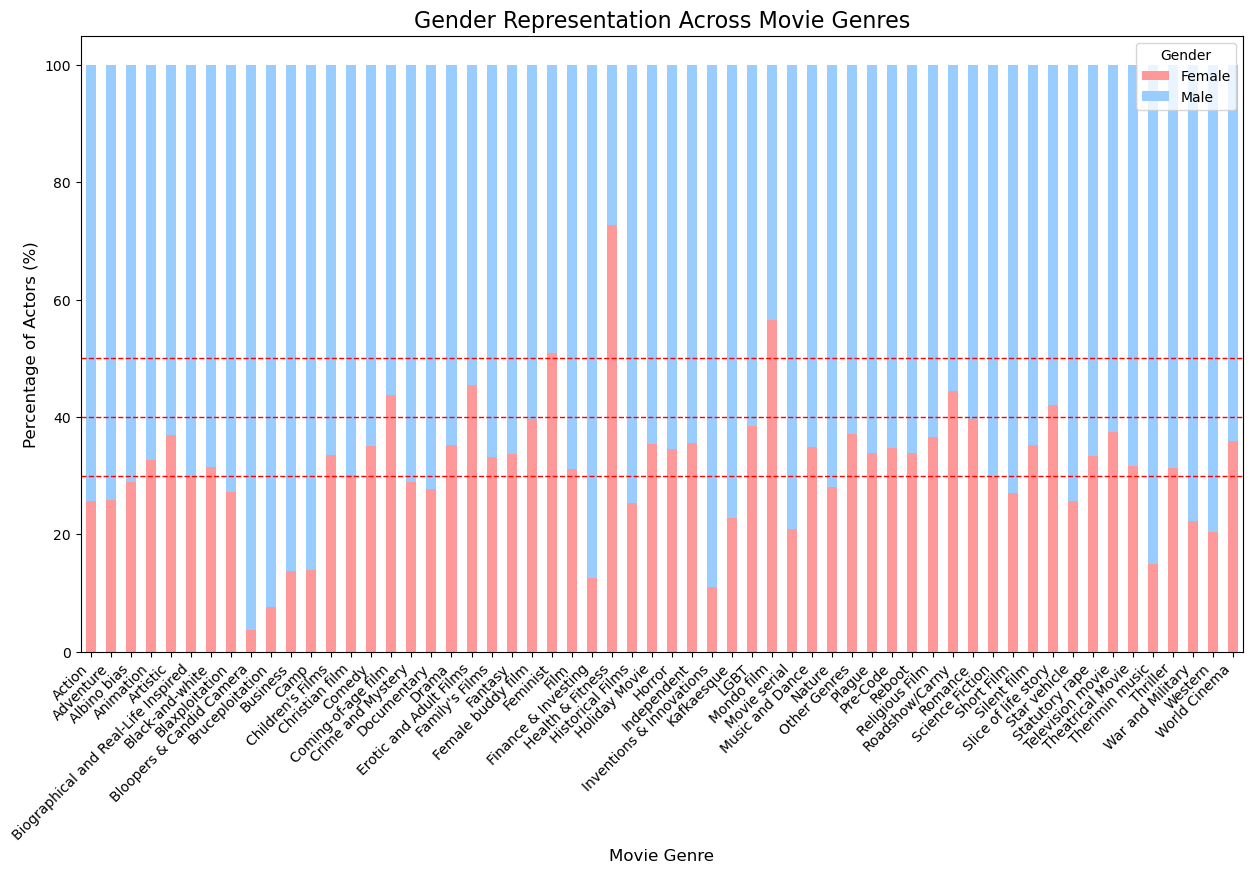

In [124]:
genre_gender_counts = movies_genres_df.explode("actor_genders").explode("movie_genres")
gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)

gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots()
gender_genre_percentages.plot(kind="bar", stacked=True, figsize=(15, 8), color=["#FF9999", "#99CCFF"], ax=ax)
ax.set_title("Gender Representation Across Movie Genres", fontsize=16)
ax.set_ylabel("Percentage of Actors (%)", fontsize=12)
ax.set_xlabel("Movie Genre", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.legend(title="Gender", labels=["Female", "Male"], loc="upper right")

ax.axhline(y=50, color="red", linestyle="--", linewidth=1)
ax.axhline(y=40, color="red", linestyle="--", linewidth=1)
ax.axhline(y=30, color="red", linestyle="--", linewidth=1)


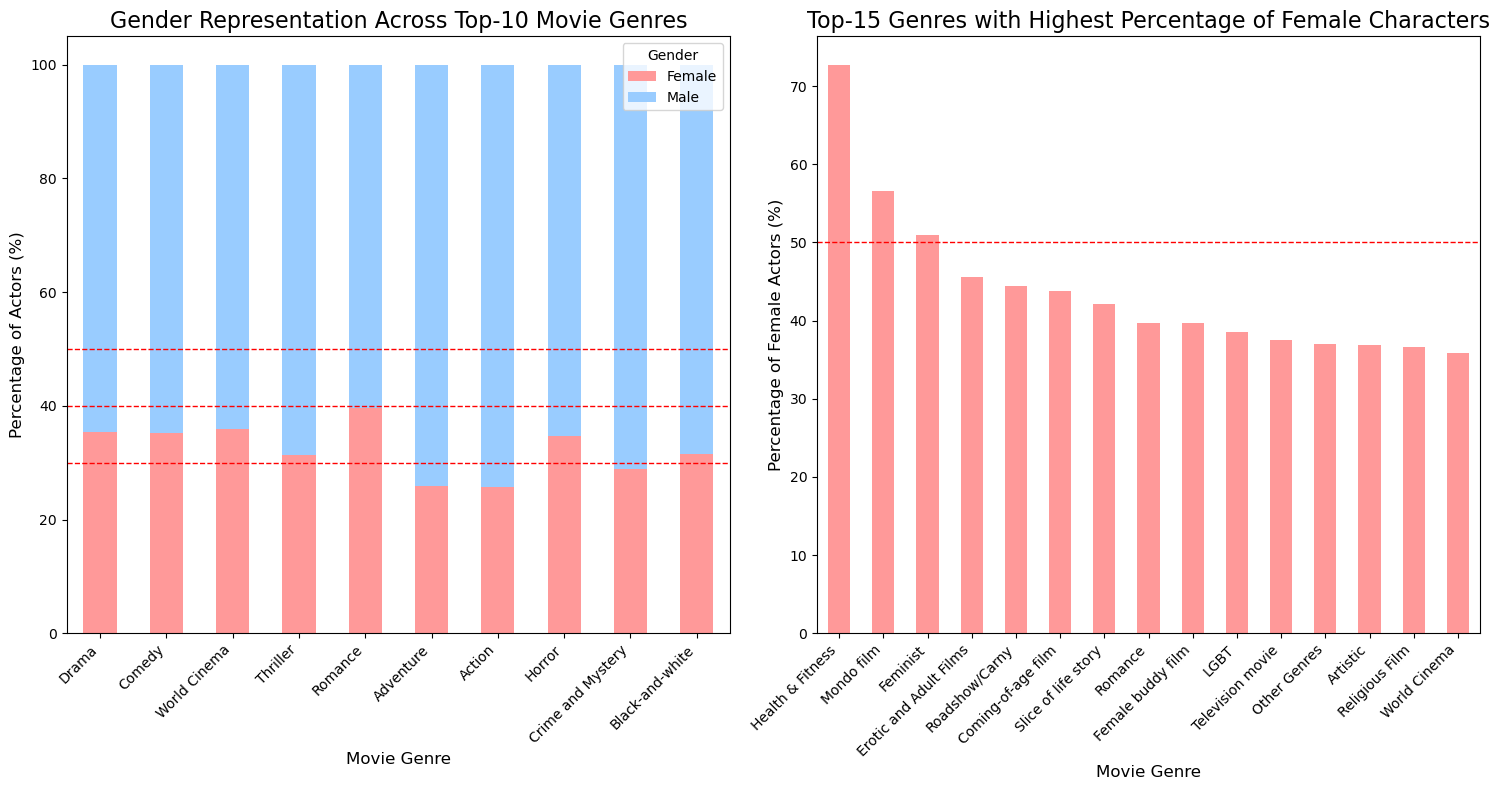

In [128]:
# Step 1: Top-10 genres by actor count
# We will count the occurrences of movie genres and actor genders
genre_gender_counts = movies_genres_df.explode("actor_genders").explode("movie_genres")
gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)

# Normalize for percentages
gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100

# Count the number of actors per genre (for the top-10 by genre count)
genre_counts = genre_gender_counts.groupby('movie_genres').size().sort_values(ascending=False).head(10)

# Step 2: Plot top-10 genres by actor count
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Plot the top-10 genres by actor count
gender_genre_counts = gender_genre_counts.loc[genre_counts.index]  # Filter by top-10 genres
gender_genre_percentages_10 = gender_genre_percentages.loc[genre_counts.index]

gender_genre_percentages_10.plot(kind="bar", stacked=True, figsize=(15, 8), color=["#FF9999", "#99CCFF"], ax=ax[0])
ax[0].set_title("Gender Representation Across Top-10 Movie Genres", fontsize=16)
ax[0].set_ylabel("Percentage of Actors (%)", fontsize=12)
ax[0].set_xlabel("Movie Genre", fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax[0].legend(title="Gender", labels=["Female", "Male"], loc="upper right")
ax[0].axhline(y=50, color="red", linestyle="--", linewidth=1)
ax[0].axhline(y=40, color="red", linestyle="--", linewidth=1)
ax[0].axhline(y=30, color="red", linestyle="--", linewidth=1)

# Step 3: Top-10 genres with the highest percentage of female actors
# Sort the genres based on the percentage of female actors and plot the top 10
top_10_genres_female_percentage = gender_genre_percentages["F"].sort_values(ascending=False).head(15)

# Plot top-10 genres with the highest percentage of female characters
top_10_genres_female_percentage.plot(kind="bar", figsize=(15, 8), color="#FF9999", ax=ax[1])
ax[1].set_title("Top-15 Genres with Highest Percentage of Female Characters", fontsize=16)
ax[1].set_ylabel("Percentage of Female Actors (%)", fontsize=12)
ax[1].set_xlabel("Movie Genre", fontsize=12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax[1].axhline(y=50, color="red", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


Female buddy film?

/var/folders/cd/kjm5mz3n3gggv0ytrmlp1nvr0000gp/T/ipykernel_18164/2798237074.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)


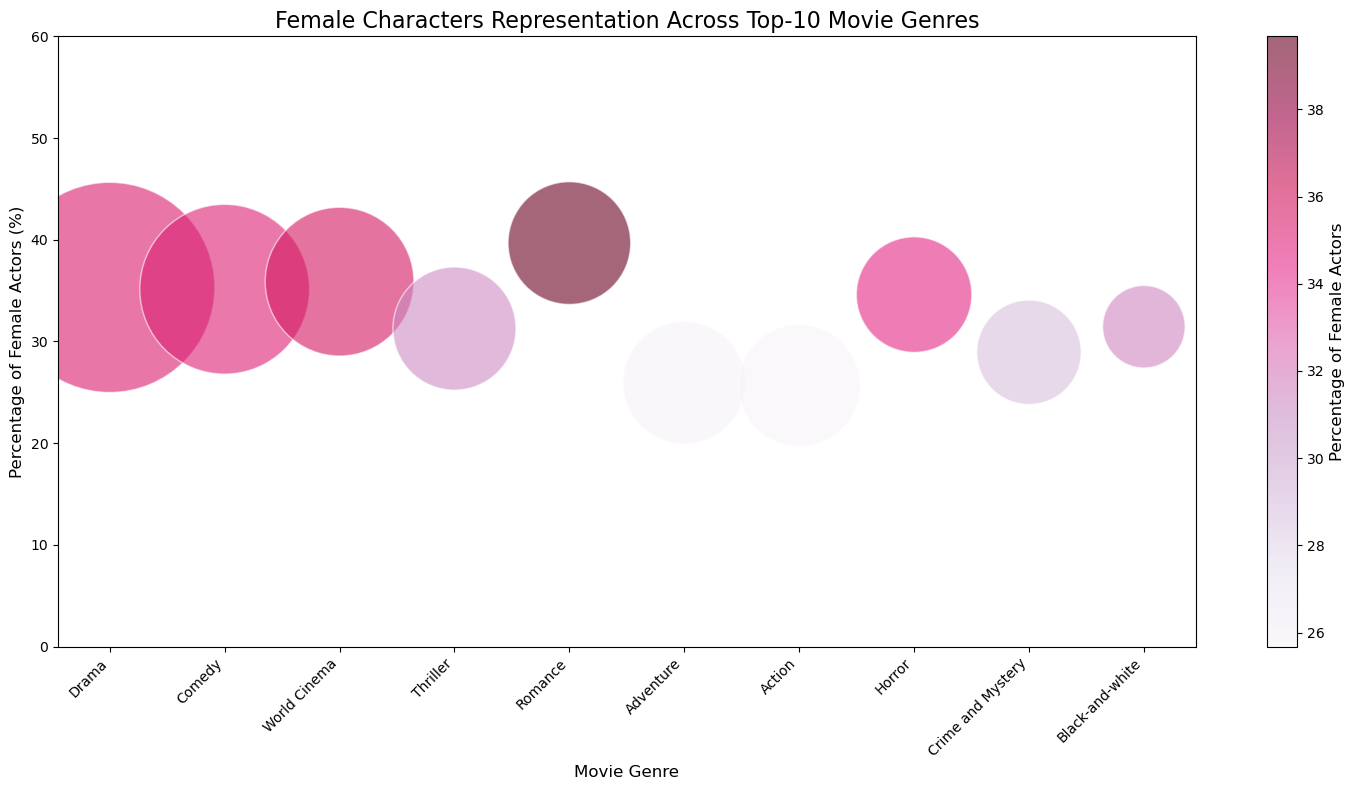

In [138]:
# Filter out the data to include only the top-10 genres by actor count
genre_gender_counts = movies_genres_df.explode("actor_genders").explode("movie_genres")
gender_genre_counts = genre_gender_counts.groupby(['movie_genres', 'actor_genders']).size().unstack(fill_value=0)
gender_genre_percentages = gender_genre_counts.div(gender_genre_counts.sum(axis=1), axis=0) * 100

# Count the number of actors per genre (for the top-10 by genre count)
genre_counts = genre_gender_counts.groupby('movie_genres').size().sort_values(ascending=False).head(10)
top_10_genres = genre_counts.index
gender_genre_counts_top_10 = gender_genre_counts.loc[top_10_genres]
gender_genre_percentages_top_10 = gender_genre_percentages.loc[top_10_genres]

# Calculate total number of actors per genre (used for bubble size)
total_actors_per_genre_top_10 = gender_genre_counts_top_10.sum(axis=1)

# Calculate the percentage of female actors per genre
female_percentage_top_10 = gender_genre_percentages_top_10["F"]

# Now, create a bubble chart
fig, ax = plt.subplots(figsize=(15, 8))

# Plot the scatter plot (bubble chart)
scatter = ax.scatter(
    x=female_percentage_top_10.index,  # Genres
    y=female_percentage_top_10,        # Percentage of Female Actors
    s=total_actors_per_genre_top_10 * 0.1,  # Bubble size, scale for better visualization
    c=female_percentage_top_10,        # Color by percentage of female actors
    cmap='PuRd',                    # Color map for visual appeal
    alpha=0.6,                          # Transparency of bubbles
    edgecolors="w",                     # White edges for better visualization
)

# Customize the chart
ax.set_title("Female Characters Representation Across Top-10 Movie Genres", fontsize=16)
ax.set_ylabel("Percentage of Female Actors (%)", fontsize=12)
ax.set_xlabel("Movie Genre", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_ylim(0, 60)

# Add color bar to show the percentage of female actors
cbar = plt.colorbar(scatter)
cbar.set_label("Percentage of Female Actors", fontsize=12)

plt.tight_layout()
plt.show()


### 2.1.6.2 Gender, genre, country

In [41]:
movies_genres_country_df = movies_metadata_df.copy(deep=True)
# only interesting columns
movies_genres_country_df = movies_genres_country_df[["wikipedia_movie_id", "movie_release_date", "movie_genres", "movie_countries"]]
# merging
movies_genres_country_df = movies_genres_country_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")

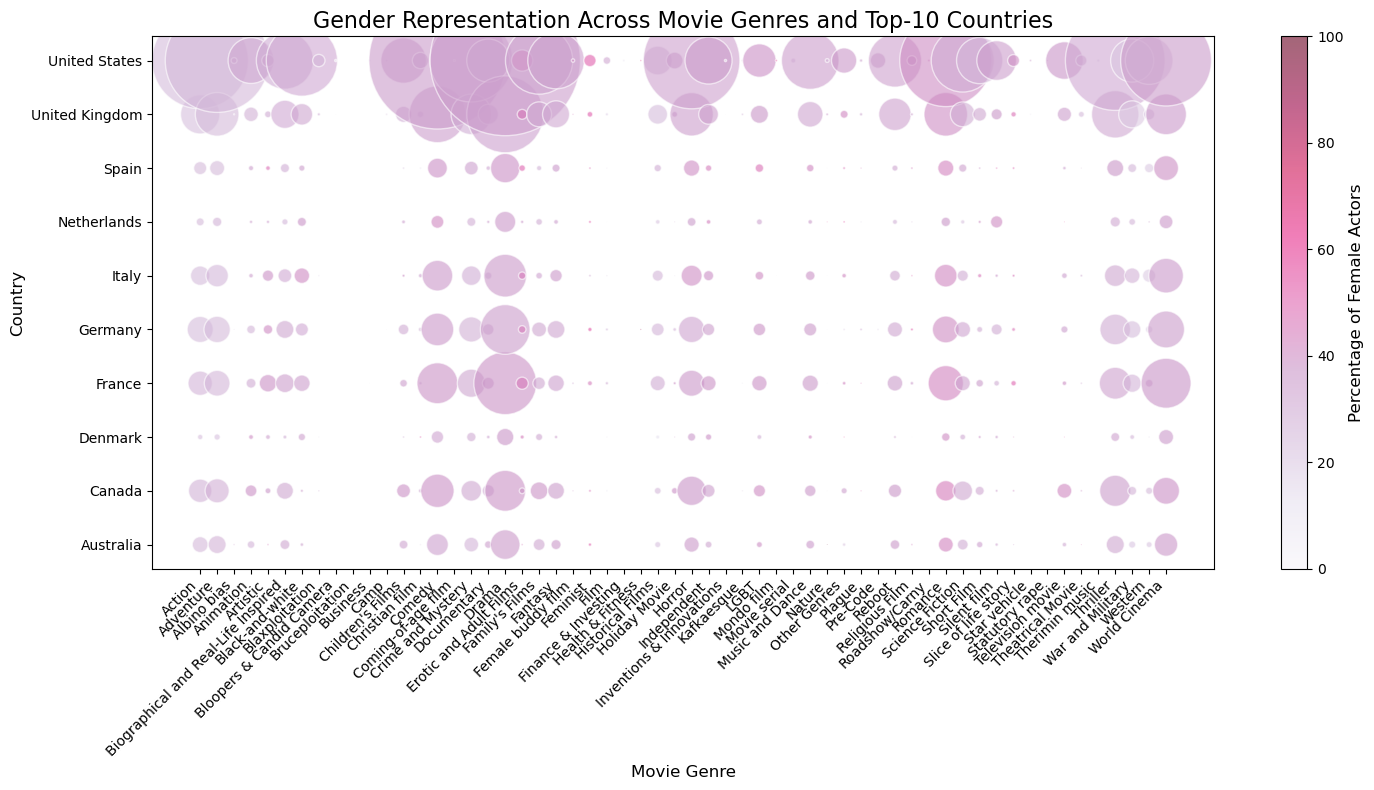

In [207]:
# Ensure 'movie_countries' and 'movie_genres' are exploded
genre_country_gender_counts = movies_genres_country_df.explode("actor_genders").explode("movie_genres").explode("movie_countries")

# Calculate gender counts for each genre, country, and gender
genre_country_gender_counts = genre_country_gender_counts.groupby(['movie_genres', 'movie_countries', 'actor_genders']).size().unstack(fill_value=0)

# Calculate the percentage of female actors for each combination
gender_percentage = genre_country_gender_counts['F'] / genre_country_gender_counts.sum(axis=1) * 100

# Get the total number of actors in each combination for bubble size
total_actors = genre_country_gender_counts.sum(axis=1)

# Get the top-10 countries by actor count
countries = sorted(genre_country_gender_counts.groupby('movie_countries').size().sort_values(ascending=False).head(10).index)

# Filter gender_percentage and genre_country_gender_counts to include only top-10 countries
gender_percentage_top_10_countries = gender_percentage[gender_percentage.index.get_level_values('movie_countries').isin(countries)]
genre_country_gender_counts_top_10_countries = genre_country_gender_counts.loc[gender_percentage_top_10_countries.index]

# Now, create the bubble chart
fig, ax = plt.subplots(figsize=(15, 8))

# Bubble size (scaled by total number of actors)
bubble_size = total_actors.loc[gender_percentage_top_10_countries.index] * 0.1  # Adjust this factor for better visualization

# Map the genres to the x-axis (ensure genres are unique and sorted)
genres = sorted(genre_country_gender_counts.index.get_level_values('movie_genres').unique())

# Plot the scatter plot (bubble chart)
scatter = ax.scatter(
    x=[genres.index(genre) for genre in gender_percentage_top_10_countries.index.get_level_values('movie_genres')],  # x-axis: genres
    y=[countries.index(country) for country in gender_percentage_top_10_countries.index.get_level_values('movie_countries')],  # y-axis: countries
    s=bubble_size,  # Bubble size based on total actors
    c=gender_percentage.loc[gender_percentage_top_10_countries.index],  # Color by percentage of female actors
    cmap='PuRd',  # Color map for visual appeal
    alpha=0.6,  # Transparency of bubbles
    edgecolors="w",  # White edges for better visualization
)

# Customize the chart
ax.set_title("Gender Representation Across Movie Genres and Top-10 Countries", fontsize=16)
ax.set_xlabel("Movie Genre", fontsize=12)
ax.set_ylabel("Country", fontsize=12)

# Set x-tick labels and rotation
ax.set_xticks(np.arange(len(genres)))
ax.set_xticklabels(genres, rotation=45, ha="right", fontsize=10)

# Set y-tick labels for countries
ax.set_yticks(np.arange(len(countries)))
ax.set_yticklabels(countries, fontsize=10)

# Add color bar to show the percentage of female actors
cbar = plt.colorbar(scatter)
cbar.set_label("Percentage of Female Actors", fontsize=12)

plt.tight_layout()
plt.show()


### 2.1.7 Gender representation in the movie runtime

/var/folders/cd/kjm5mz3n3gggv0ytrmlp1nvr0000gp/T/ipykernel_18164/1782226022.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_counts = df_exploded.groupby(['runtime_bin', 'actor_genders']).size().unstack(fill_value=0)


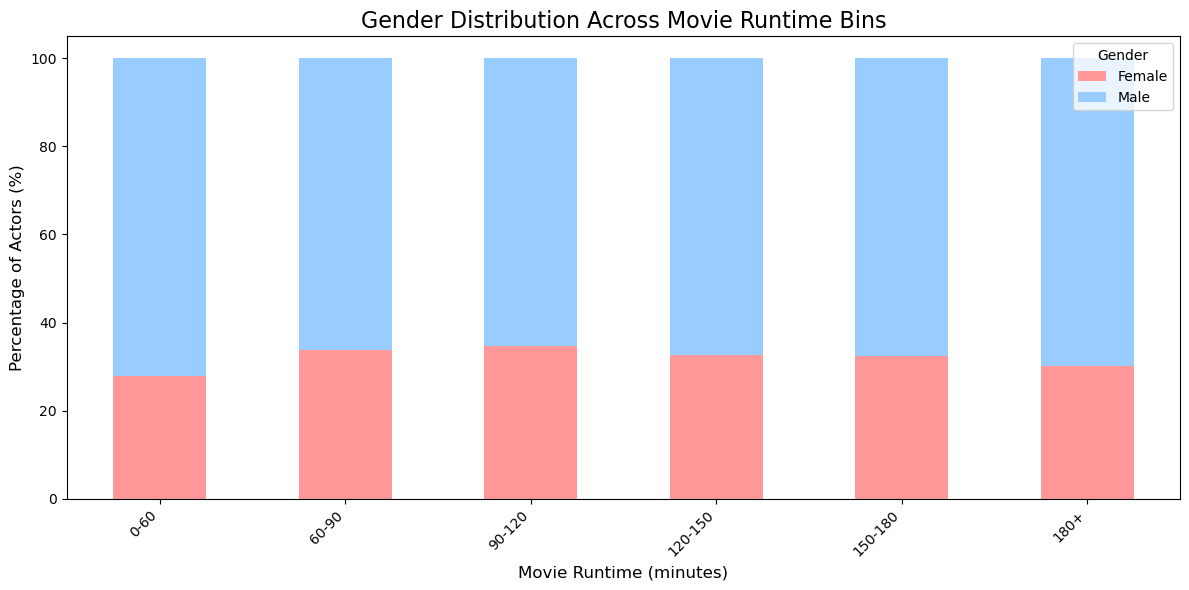

In [149]:
movies_runtime_df = movies_metadata_df.copy(deep=True)
# only interesting columns
movies_runtime_df = movies_runtime_df[["wikipedia_movie_id", "movie_release_date", "movie_runtime"]]
# merging
movies_runtime_df = movies_runtime_df.merge(genders_grouped, on="wikipedia_movie_id", how="left")
movies_runtime_df.dropna(subset="movie_runtime", inplace=True)

# Bin movie runtimes into ranges
bins = [0, 60, 90, 120, 150, 180, float('inf')]  # Define the runtime bins
labels = ['0-60', '60-90', '90-120', '120-150', '150-180', '180+']  # Labels for the bins
movies_runtime_df['runtime_bin'] = pd.cut(movies_runtime_df['movie_runtime'], bins=bins, labels=labels, right=False)

# Explode the actor_genders column to count genders for each movie
df_exploded = movies_runtime_df.explode('actor_genders')

# Count gender distribution per movie
gender_counts = df_exploded.groupby(['runtime_bin', 'actor_genders']).size().unstack(fill_value=0)

# Calculate the percentage of each gender per bin
gender_percentage = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100

# Create the figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the gender distribution per runtime bin
gender_percentage.plot(kind='bar', stacked=True, color=["#FF9999", "#99CCFF"], ax=ax)

# Customize the chart
ax.set_title("Gender Distribution Across Movie Runtime Bins", fontsize=16)
ax.set_ylabel("Percentage of Actors (%)", fontsize=12)
ax.set_xlabel("Movie Runtime (minutes)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.legend(title="Gender", labels=["Female", "Male"], loc="upper right")

# Adjust layout
plt.tight_layout()

## 2.2. CHARACTER TYPES

In [150]:
# we keep unique values
character_types = tvtropes_df['character_type'].unique()

In [151]:
tvtropes_df.head()

,character_type,metadata
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


Here, we separate the columns so it is more easy to understand.

In [182]:
tvtropes_df['metadata'] = tvtropes_df['metadata'].apply(ast.literal_eval)
tvtropes_df = pd.concat([tvtropes_df.drop(['metadata'], axis=1), tvtropes_df['metadata'].apply(pd.Series)], axis=1)
tvtropes_df = tvtropes_df.rename(columns={'char': 'char_name', 'actor': 'actor_name', 'movie': 'movie_name', 'id': 'char_actor_id'})
# We add the character information and especially its gender
tvtropes_df['actor_gender'] = tvtropes_df['actor_name'].map(char_metadata_df.set_index('actor_name')['actor_gender'].to_dict())

tvtropes_df.head()

,character_type,char_name,movie_name,char_actor_id,actor_name,actor_gender
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M


We count the number of female and male characters. There is much more males, which introduces some bias in our analysis. We are not sure if we want to use this file since it could contain biased information about genders, and the file is only 500 rows so it is quite small.

In [154]:
tvtropes_df.groupby('actor_gender').size().reset_index(name='counts')

,actor_gender,counts
0,F,69
1,M,432


We plot the repartition of the gender characters along the tv tropes.

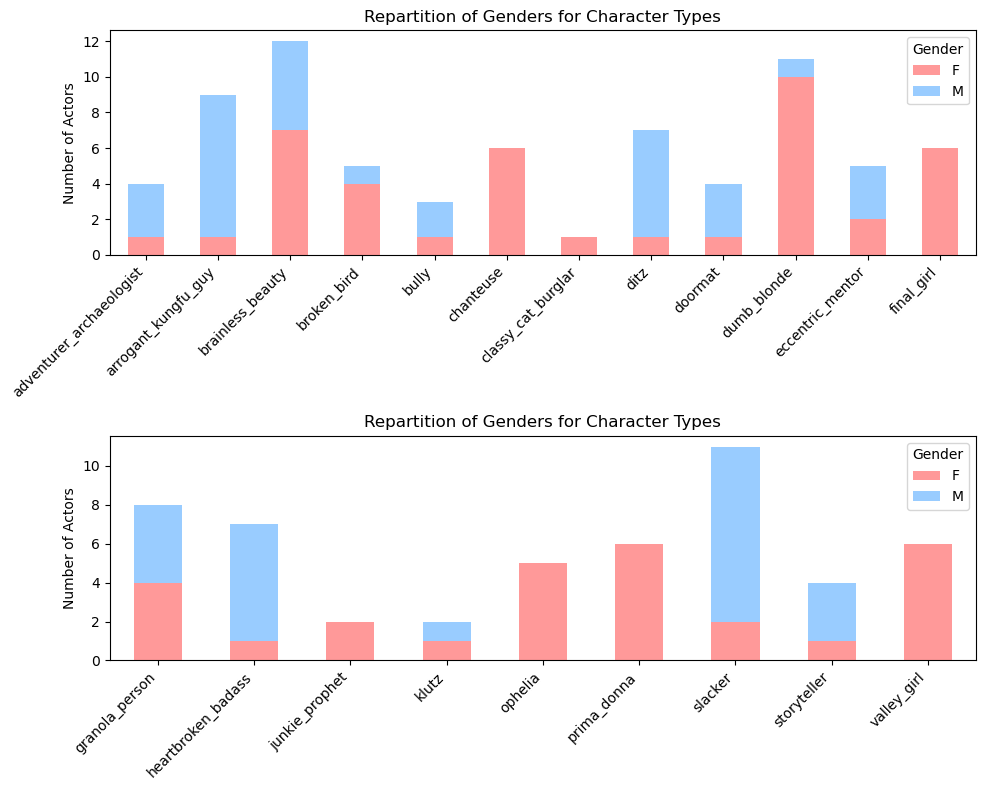

In [153]:
# Filter rows where 'actor_gender' contains 'F'
character_type_gender_counts = tvtropes_df.groupby(['character_type', 'actor_gender']).size().unstack(fill_value=0)
filtered_character_type_gender_counts = character_type_gender_counts[character_type_gender_counts['F'] > 0]

# Set up the number of subplots
categories_per_subplot = 12
num_subplots = (len(filtered_character_type_gender_counts) + categories_per_subplot - 1) // categories_per_subplot

fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 4 * num_subplots))

# Plot each subset in a separate subplot
for i in range(num_subplots):
    start = i * categories_per_subplot
    end = start + categories_per_subplot
    subset = filtered_character_type_gender_counts.iloc[start:end]

    subset.plot(kind='bar', stacked=True, ax=axes[i], color=["#FF9999", "#99CCFF"])
    axes[i].set_title(f"Repartition of Genders for Character Types")
    axes[i].set_xlabel("")  # Character type
    axes[i].set_ylabel("Number of Actors")
    axes[i].legend(title="Gender")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()


Here, we only plotted the categories that have some female characters. As expected following societal cliches, female characters are often juged based on their appearance (ex :"dumb blond") whereas more flatterous characters are predominantly males such as "byronic_hero" or "master_swodsman". Some categories are 100% female characters: chanteuse, final_girl, ophelia, prima_donna, valley_girl. Indeed, some genders word are contained in the title of the tv tropes. As for the category brainless beauty, we observe it is almost 50-50 but considering there is really less female characters, it is obvious to see that it is disproportionate.

### 2.2.1 Genders, tv tropes and genres

In [183]:
# Complete tvtropes to get the movie ID, using the name of the movie and the char_actor_id, to get movie genres and countries
# we first need to add the movie_name column in the char_metadata_df
char_movie_df = pd.merge(
    char_metadata_df,
    movies_metadata_df[['wikipedia_movie_id', 'movie_name', "movie_countries", "movie_genres"]],  # Only need char_id and wikipedia_movie_id
    how='left',  # Use left join to keep all rows from tv_tropes_df
    on=['wikipedia_movie_id']  # Merge on char_id and movie_name
)
# now we can complete tvtropes
tvtropes_completed_df = pd.merge(
    tvtropes_df,
    char_movie_df[['char_actor_id', 'movie_name', 'wikipedia_movie_id', "movie_countries", "movie_genres", "movie_release_date"]],  # Only need char_id and wikipedia_movie_id
    how='left',  # Use left join to keep all rows from tv_tropes_df
    on=['char_actor_id', 'movie_name']  # Merge on char_id and movie_name
)

/var/folders/cd/kjm5mz3n3gggv0ytrmlp1nvr0000gp/T/ipykernel_18164/592460712.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)


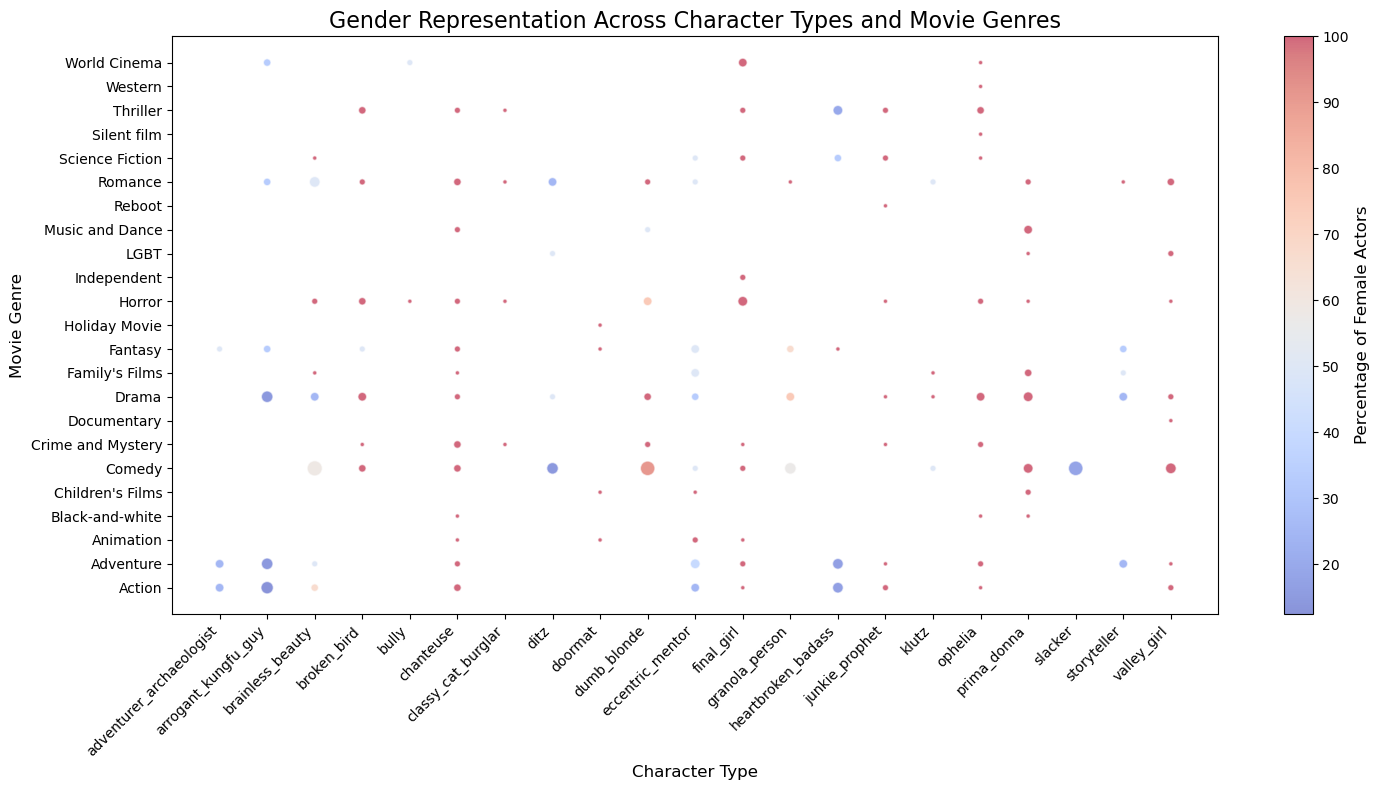

In [195]:
# Ensure 'movie_genres' is exploded so we have a row per genre per character type
tvtropes_with_genres = tvtropes_completed_df.explode('movie_genres')

# Get gender counts for each character type and genre
character_type_genre_gender_counts = tvtropes_with_genres.groupby(['character_type', 'movie_genres', 'actor_gender']).size().unstack(fill_value=0)

# Filter the data to only include rows where female actors ('F') are present
character_type_genre_gender_counts = character_type_genre_gender_counts[character_type_genre_gender_counts['F'] > 0]

# Calculate the percentage of female actors in each combination
gender_percentage = character_type_genre_gender_counts['F'] / character_type_genre_gender_counts.sum(axis=1) * 100

# Get the total number of actors in each combination for bubble size
total_actors = character_type_genre_gender_counts.sum(axis=1)

# Now, we create the bubble plot
fig, ax = plt.subplots(figsize=(15, 8))

# Define bubble size (scaled by total actors)
bubble_size = total_actors * 10  # Adjust this factor as needed

# Map the genres to the y-axis (ensure genres are unique and sorted)
genres = sorted(character_type_genre_gender_counts.index.get_level_values('movie_genres').unique())

# Plot the bubble chart
scatter = ax.scatter(
    x=gender_percentage.index.get_level_values('character_type'),  # x-axis: character types
    y=[genres.index(genre) for genre in gender_percentage.index.get_level_values('movie_genres')],  # y-axis: genres
    s=bubble_size,  # bubble size
    c=gender_percentage,  # Color by female percentage
    cmap='coolwarm',  # Color map
    alpha=0.6,  # Transparency
    edgecolors="w",  # White edge color
)

# Customize the plot
ax.set_title("Gender Representation Across Character Types and Movie Genres", fontsize=16)
ax.set_xlabel("Character Type", fontsize=12)
ax.set_ylabel("Movie Genre", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Set y-ticks and labels for genres
ax.set_yticks(np.arange(len(genres)))
ax.set_yticklabels(genres, fontsize=10)

# Add a color bar for the gender percentage
cbar = plt.colorbar(scatter)
cbar.set_label("Percentage of Female Actors", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### 2.2.2 Tvtropes, genders and countries

/var/folders/cd/kjm5mz3n3gggv0ytrmlp1nvr0000gp/T/ipykernel_18164/72912184.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)


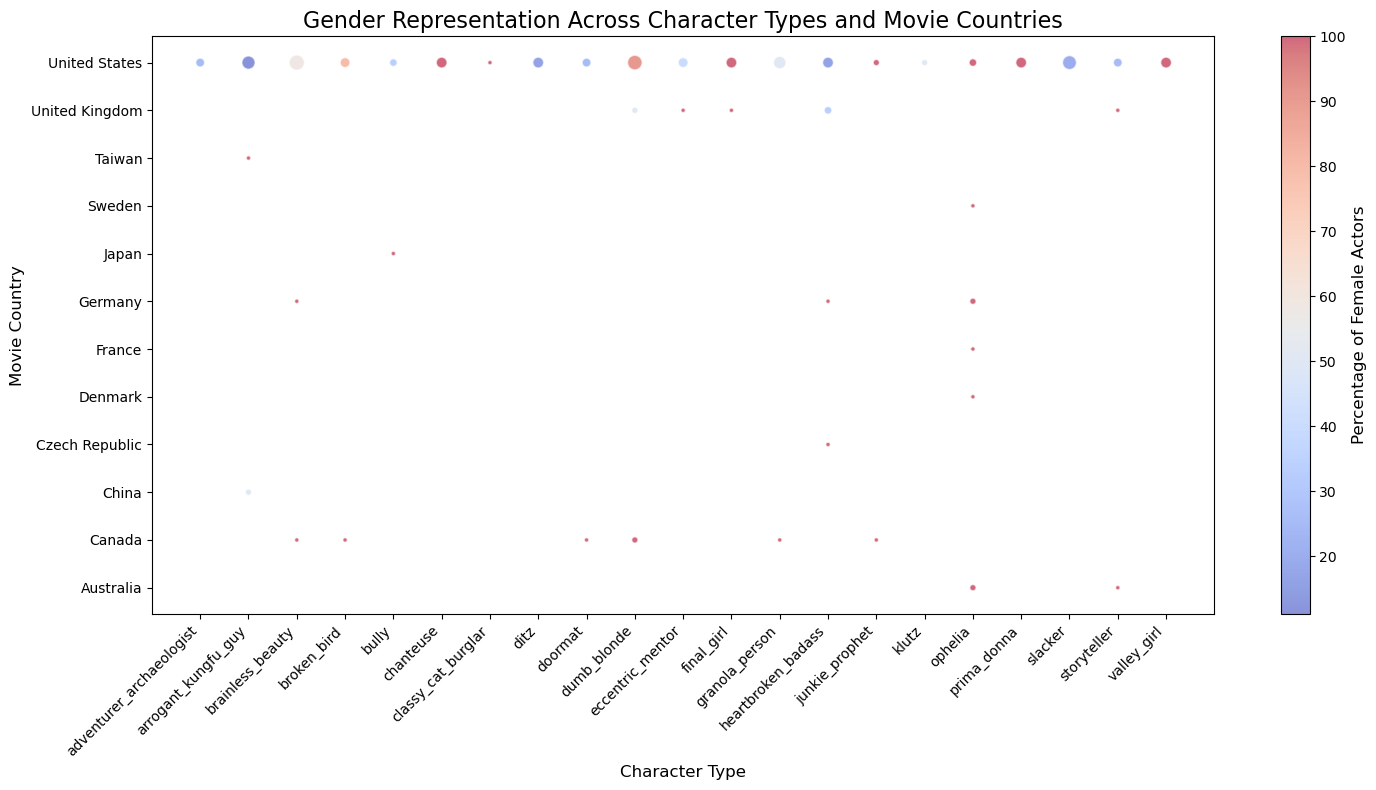

In [196]:
# Ensure 'movie_countries' is exploded so we have a row per country per character type
tvtropes_with_countries = tvtropes_completed_df.explode('movie_countries')

# Get gender counts for each character type and country
character_type_country_gender_counts = tvtropes_with_countries.groupby(['character_type', 'movie_countries', 'actor_gender']).size().unstack(fill_value=0)

# Filter the data to only include rows where female actors ('F') are present
character_type_country_gender_counts = character_type_country_gender_counts[character_type_country_gender_counts['F'] > 0]

# Calculate the percentage of female actors in each combination
gender_percentage = character_type_country_gender_counts['F'] / character_type_country_gender_counts.sum(axis=1) * 100

# Get the total number of actors in each combination for bubble size
total_actors = character_type_country_gender_counts.sum(axis=1)

# Now, we create the bubble plot
fig, ax = plt.subplots(figsize=(15, 8))

# Define bubble size (scaled by total actors)
bubble_size = total_actors * 10  # Adjust this factor as needed

# Map the countries to the y-axis (ensure countries are unique and sorted)
countries = sorted(character_type_country_gender_counts.index.get_level_values('movie_countries').unique())

# Plot the bubble chart
scatter = ax.scatter(
    x=gender_percentage.index.get_level_values('character_type'),  # x-axis: character types
    y=[countries.index(country) for country in gender_percentage.index.get_level_values('movie_countries')],  # y-axis: countries
    s=bubble_size,  # bubble size
    c=gender_percentage,  # Color by female percentage
    cmap='coolwarm',  # Color map
    alpha=0.6,  # Transparency
    edgecolors="w",  # White edge color
)

# Customize the plot
ax.set_title("Gender Representation Across Character Types and Movie Countries", fontsize=16)
ax.set_xlabel("Character Type", fontsize=12)
ax.set_ylabel("Movie Country", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Set y-ticks and labels for countries
ax.set_yticks(np.arange(len(countries)))
ax.set_yticklabels(countries, fontsize=10)

# Add a color bar for the gender percentage
cbar = plt.colorbar(scatter)
cbar.set_label("Percentage of Female Actors", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## 2.3. CHARACTER NAMES 

For now, we will not analyze the character names.

In [35]:
name_clusters_df

,Cluster_name,Char_actor_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
...,...,...
2661,John Rolfe,/m/0k5_ql
2662,John Rolfe,/m/02vd6vs
2663,Elizabeth Swann,/m/0k1xvz
2664,Elizabeth Swann,/m/0k1x_d


## 3. PLOT SUMMARIES

We focused our analysis on the content of plot summaries by using sentiment analysis on each plot, linking it to the dominent emotion.

In [66]:
# converting cols to same type
plot_summaries_df['wikipedia_movie_id'] = plot_summaries_df['wikipedia_movie_id'].astype(str)
movies_metadata_df['wikipedia_movie_id'] = movies_metadata_df['wikipedia_movie_id'].astype(str)

# Keep only the movies that are common to our movies dataset
plot_summaries_filtered_df = plot_summaries_df[plot_summaries_df['wikipedia_movie_id'].isin(movies_metadata_df['wikipedia_movie_id'])]
plot_summaries_filtered_df.reset_index(drop=True, inplace=True)

In [67]:
plot_summaries_df.shape

(42306, 2)

In [68]:
plot_summaries_filtered_df.shape

(35813, 2)

Investigating the length of the plots, we see that the majority of the plots are between 50 and 250 words long. 

In [37]:
# charge pipeline for emotion detection
emotion_pipeline = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/anaconda3/envs/MA1/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Then, we perform a sentiment analysis using Hugging Face transformers pipeline.

In [38]:
# Function for analyzing the emotion of a text

def emotion_analysis(text):
    chunks = [text[i:i+512] for i in range(0, len(text), 512)]
    results = [emotion_pipeline(chunk) for chunk in chunks]

    # Initialize a dictionary to accumulate scores for each emotion
    emotion_scores = defaultdict(list)

    #Process each chunk and accumulate scores
    for chunk_result in results:
        for emotion in chunk_result:
            for i in range(len(emotion)):
                emotion_scores[emotion[i]['label']].append(emotion[i]['score'])
            #print(emotion_scores[emotion['label']])
            #emotion_scores[emotion['label']].append(emotion['score'])

    # Calculate the average score for each emotion
    average_scores = {emotion: sum(scores) / len(scores) for emotion, scores in emotion_scores.items()}

    return average_scores

In [39]:
# get the emotions and dominant emotion for the first n plots
def n_first_emotions(n, df):
    df = plot_summaries_df.head(n)
    df['emotion_scores'] = df['plot_summary'].progress_apply(emotion_analysis)
    df['dominant_emotion'] = df['emotion_scores'].apply(lambda x: max(x, key=x.get))
    return df

In [69]:
# Analyzing emotions of the first 2000 plot summaries
summary_emotions_df = n_first_emotions(plot_summaries_filtered_df.shape[0], plot_summaries_filtered_df)
summary_emotions_df['dominant_emotion'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Distribution of the dominant emotions for the first 2000 movies')
plt.xlabel('Dominant emotion')
plt.ylabel('Number of movies')
plt.xticks(rotation=45, ha='right')
plt.show()


 89%|████████▉ | 31931/35813 [5:18:35<38:43,  1.67it/s]


IndexError: index out of range in self

We see that more film summaries are categorised as including anger, whereas few contain joy or surprise. For further analysis, we want to investigate the potential relationship between the emotions and the genders of the main actors.

In [72]:
# We export the emotion df because it takes a while to compute !
summary_emotions_df.head()

NameError: name 'summary_emotions_df' is not defined

## Plot summaries and gender repartition

In [54]:
emotions_df = df_plot_emotions_2000.copy(deep=True)
emotions_df = emotions_df[["wikipedia_movie_id", "dominant_emotion"]]
# converting both cols to str
emotions_df['wikipedia_movie_id'] = emotions_df['wikipedia_movie_id'].astype(str)
movies_genres_country_df['wikipedia_movie_id'] = movies_genres_country_df['wikipedia_movie_id'].astype(str)

In [55]:
emotions_df = pd.merge(emotions_df, movies_genres_country_df, how="left", on="wikipedia_movie_id").dropna(subset="movie_release_date").reset_index(drop=True)
emotions_df.head()

,wikipedia_movie_id,dominant_emotion,movie_release_date,movie_genres,movie_countries,actor_genders
0,23890098,surprise,1990.0,"[Drama, World Cinema]","[France, Russia]","[F, M, M, M, F]"
1,31186339,anger,2012.0,"[Adventure, Science Fiction, Action, Drama]",[United States],"[F, F, M, F, M, M, F, M, F, M, M, M, M, F, F, ..."
2,20663735,anger,2000.0,"[Music and Dance, Action, Drama, World Cinema]",[India],"[M, M, M, F, M, M, M, F, M, F, M, M]"
3,2231378,joy,1951.0,[Comedy],[United States],"[F, M, F, F, F, M, M, M, M, M]"
4,595909,joy,1988.0,"[Crime and Mystery, Drama, Documentary, World ...","[United States, Australia, New Zealand]","[M, M, F, F, M, M, M, M, M, M, M, M, M, M, M, M]"


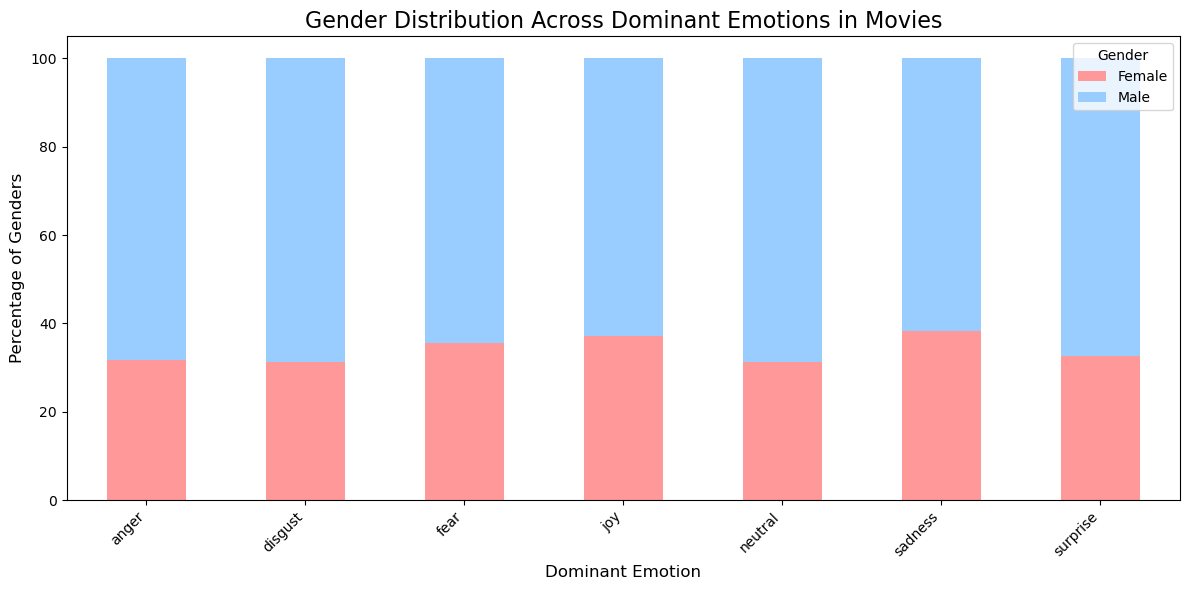

In [57]:
# Explode 'actor_genders' for individual counts
emotion_gender_df = emotions_df.explode("actor_genders")

# Group by 'dominant_emotion' and 'actor_genders' to count occurrences
emotion_gender_counts = emotion_gender_df.groupby(['dominant_emotion', 'actor_genders']).size().unstack(fill_value=0)

# Calculate percentages for each gender within each emotion
emotion_gender_percentages = emotion_gender_counts.div(emotion_gender_counts.sum(axis=1), axis=0) * 100

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))

# Create a stacked bar chart
emotion_gender_percentages.plot(
    kind='bar',
    stacked=True,
    color=["#FF9999", "#99CCFF"],  # Colors for Female and Male
    ax=ax
)

# Customize the plot
ax.set_title("Gender Distribution Across Dominant Emotions in Movies", fontsize=16)
ax.set_xlabel("Dominant Emotion", fontsize=12)
ax.set_ylabel("Percentage of Genders", fontsize=12)
ax.legend(title="Gender", labels=["Female", "Male"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()
